# Roll decay test parameter sensitivity

None of the methods worked well unless the initial large roll angles were removed, probably beacause the nonlinearities are higher than quadratic for this case. Removing these angles (making the model valid for only smaller angles) is one option. Another option is to allow higher order damping terms in the simulation model for the fitting (the higher order terms can later be transfered to a model with linear och quadratic order at a later stage if required). How the cutting affects the parameter identification should be further investigated.

A sensitivity stuffy regarding the impact of lowpass filtering on the parameter identification should also be conducted. 


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

import os
from scipy.optimize import curve_fit

from rolldecay.simulation import  simulate
#import rolldecay.parameter_identification as parameter_identification
import rolldecay.read_funky_ascii
import inspect
from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer
from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline


## Roll decay model test

In [3]:
ascii_path = os.path.join(rolldecay.data_path,'project1','Ascii files','20084871056k.15.asc')
df_raw = rolldecay.read_funky_ascii.read(ascii_path=ascii_path)[['phi']]

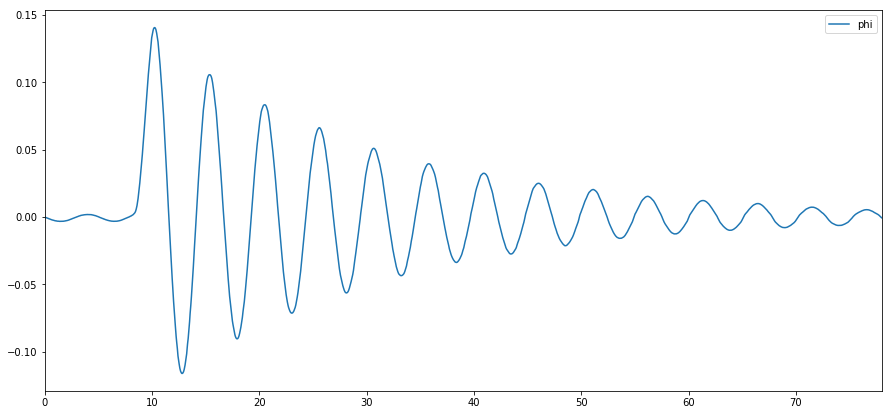

In [4]:
df_raw.plot(y='phi')

In [5]:
N=100
cutoffs = np.linspace(0.1,1,N)
scores = []
for cutoff in cutoffs:
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff, minimum_score=0)
    lowpass_filter.fit(X=df_raw)
    score = lowpass_filter.score(X=df_raw)
    scores.append(score)
    

Text(0, 0.5, 'score')

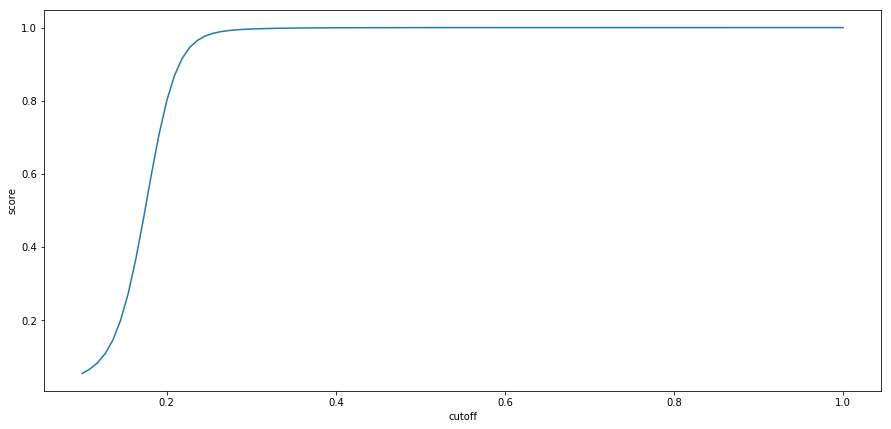

In [6]:
fig,ax = plt.subplots()
ax.plot(cutoffs, scores)
ax.set_xlabel('cutoff')
ax.set_ylabel('score')

In [7]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.4)
lowpass_filter.fit(X=df_raw)

df = lowpass_filter.transform(X=df_raw)

lowpass_filter.score(X=df_raw)

0.99937498881072

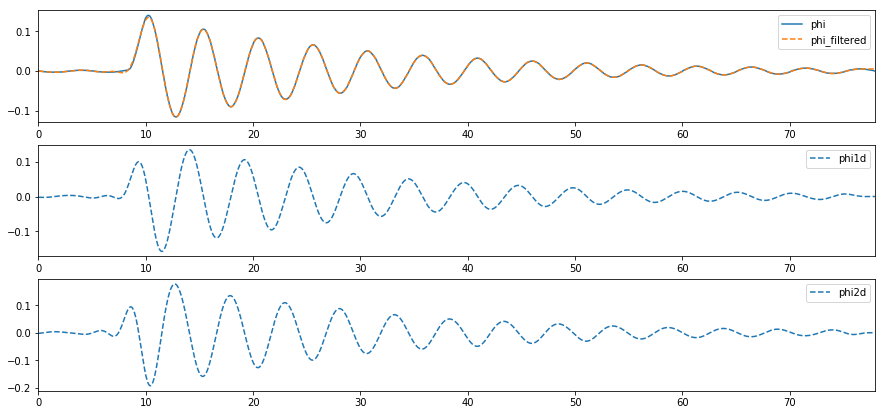

In [8]:
lowpass_filter.plot_filtering()

### Cutting the file at max value 

In [9]:
cutter = CutTransformer(phi_max=0.058, phi_min=np.deg2rad(0.5))
cutter.fit(X=df_raw)
df_cut = cutter.transform(X=df_raw)

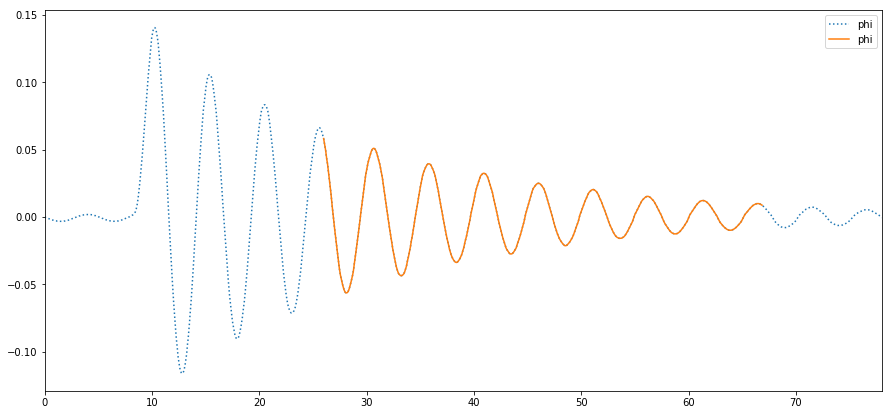

In [10]:
fig,ax = plt.subplots()
df_raw.plot(y='phi', style=':', ax=ax)
df_cut.plot(y='phi', style='-', ax=ax)


In [11]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.5)
scaler = ScaleFactorTransformer(scale_factor=29.565)
cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.05))
direct_estimator = DirectEstimator()

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('direct_estimator', direct_estimator)]
pipeline = Pipeline(steps) # define the pipeline object.

In [12]:
pipeline.fit(X=df_raw)

Pipeline(memory=None,
         steps=[('filter',
                 LowpassFilterDerivatorTransformer(cutoff=0.5,
                                                   minimum_score=0.999,
                                                   order=5)),
                ('scaler', ScaleFactorTransformer(scale_factor=29.565)),
                ('cutter',
                 CutTransformer(phi_max=0.13962634015954636,
                                phi_min=0.0008726646259971648)),
                ('direct_estimator',
                 DirectEstimator(bounds=(-inf, inf), ftol=1e-10, maxfev=4000))],
         verbose=False)

In [13]:
pipeline.score(X=df_raw)

0.9990581986265401

In [14]:
df_sim_direct = pipeline.predict(X=df_raw)

In [15]:
pipeline['cutter']

CutTransformer(phi_max=0.13962634015954636, phi_min=0.0008726646259971648)

In [16]:
direct_estimator.parameters

{'d': -0.15141849257020049,
 'omega0': 0.22647154339242795,
 'zeta': 0.04232055571760756}

In [17]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.5)
scaler = ScaleFactorTransformer(scale_factor=29.565)
cutter = CutTransformer(phi_max=np.deg2rad(8), phi_min=np.deg2rad(0.05))
norwegian_estimator = NorwegianEstimator()

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    ('norwegian_estimator', norwegian_estimator)]
pipeline2 = Pipeline(steps) # define the pipeline object.

In [18]:
pipeline2.fit(X=df_raw)

Pipeline(memory=None,
         steps=[('filter',
                 LowpassFilterDerivatorTransformer(cutoff=0.5,
                                                   minimum_score=0.999,
                                                   order=5)),
                ('scaler', ScaleFactorTransformer(scale_factor=29.565)),
                ('cutter',
                 CutTransformer(phi_max=0.13962634015954636,
                                phi_min=0.0008726646259971648)),
                ('norwegian_estimator',
                 NorwegianEstimator(bounds=(-inf, inf), ftol=1e-10, maxfev=4000))],
         verbose=False)

In [19]:
pipeline2.score(X=df_raw)

0.9991125620539946

In [20]:
np.rad2deg(df_raw['phi'].mean())

0.131659405

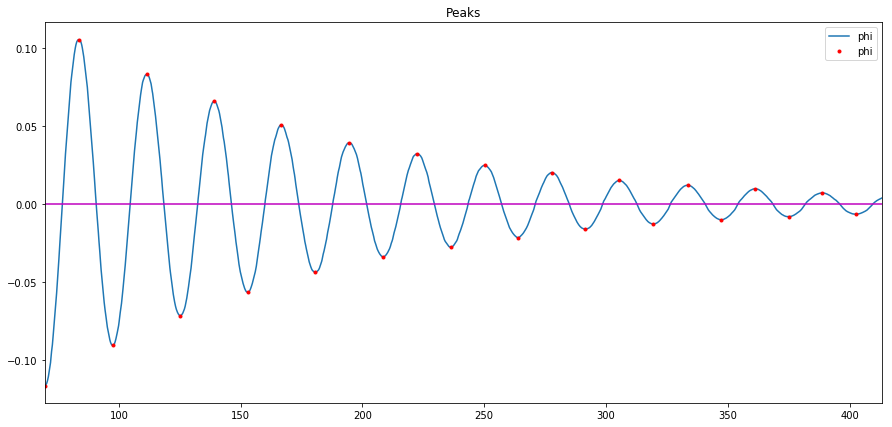

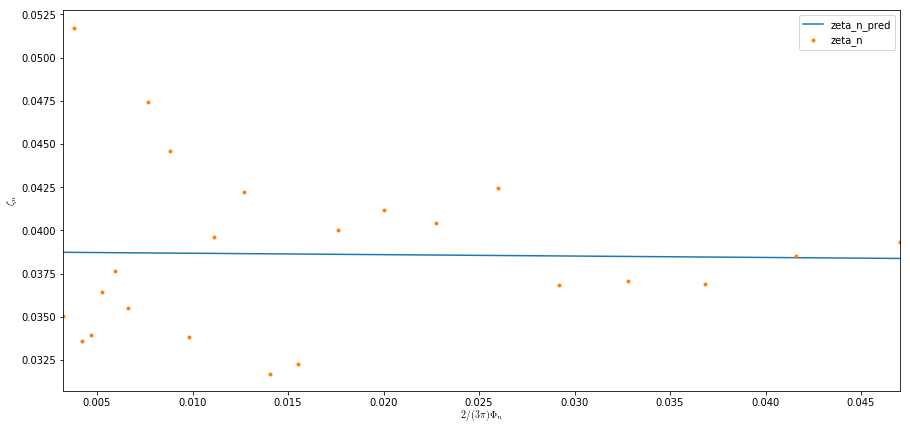

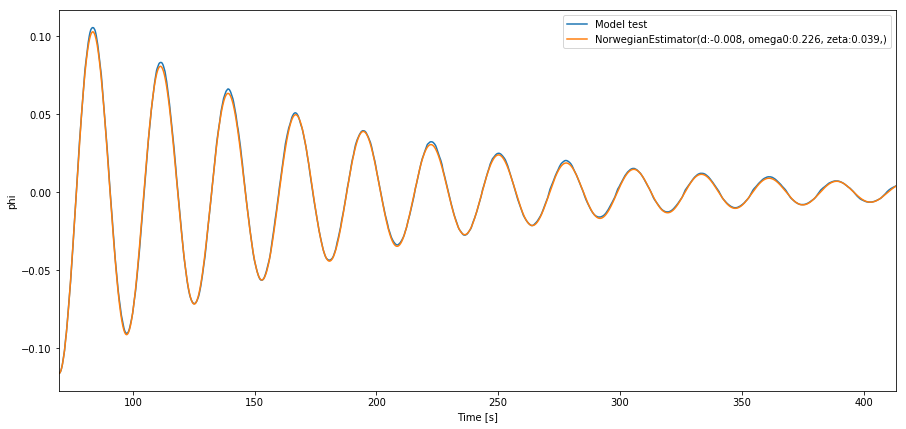

In [21]:
estimator = pipeline2['norwegian_estimator']
estimator.plot_peaks()
estimator.plot_damping()
estimator.plot_fit()

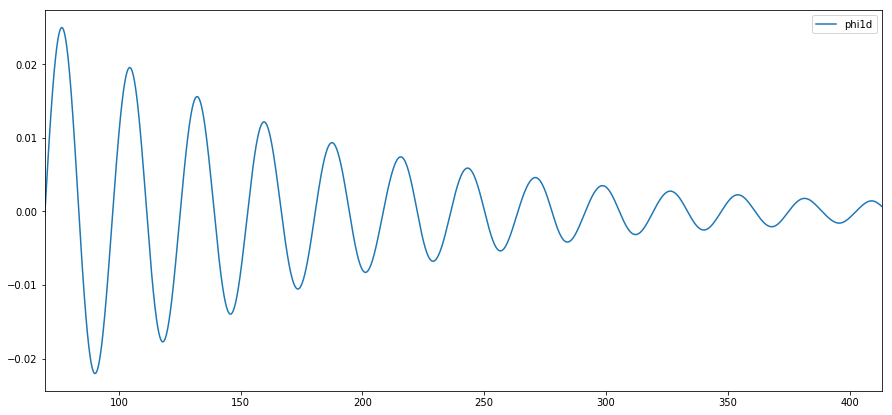

In [22]:
estimator.X.plot(y='phi1d')

## Optimize pipline

### Optimize filter

In [23]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.4, order=1, minimum_score=0.0)
lowpass_filter.fit(X=df_raw)
lowpass_filter.score(X=df_raw)

0.9645221364496558

In [24]:
scaler = ScaleFactorTransformer(scale_factor=29.565).fit(X=df_raw)
cutter = CutTransformer(phi_max=np.deg2rad(7), phi_min=np.deg2rad(0.05)).fit(X=df_raw)
direct_estimator = DirectEstimator()
norwegian_estimator = NorwegianEstimator()

N=20
cutoffs = np.linspace(0.3,1,N)
df_cuttoffs = pd.DataFrame()
df_cuttoffs_norwegian = pd.DataFrame()

for cutoff in cutoffs:
    
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff, minimum_score=0.99)
    lowpass_filter.fit(X=df_raw)   
    
    steps = [
        ('filter',lowpass_filter),
        ('scaler',scaler),
        ('cutter', cutter), 
        ('direct_estimator', direct_estimator)]
    pipeline = Pipeline(steps) # define the pipeline object.
    pipeline.fit(X=df_raw)

    s = pd.Series(pipeline['direct_estimator'].parameters)
    s['mean_damping'] = pipeline['direct_estimator'].calculate_average_linear_damping(phi_a=np.deg2rad(4))
    s['score'] = pipeline.score(X=df_raw)
    s['cutoff'] = cutoff
    df_cuttoffs = df_cuttoffs.append(s, ignore_index=True)
    
    lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=cutoff, minimum_score=0.99)
    lowpass_filter.fit(X=df_raw)   
    steps = [
        ('filter',lowpass_filter),
        ('scaler',scaler),
        ('cutter', cutter), 
        ('norwegian_estimator', norwegian_estimator)]
    pipeline2 = Pipeline(steps) # define the pipeline object.
    pipeline2.fit(X=df_raw)

    s = pd.Series(pipeline2['norwegian_estimator'].parameters)
    s['mean_damping'] = pipeline2['norwegian_estimator'].calculate_average_linear_damping(phi_a=np.deg2rad(4))
    s['score'] = pipeline2.score(X=df_raw)
    s['cutoff'] = cutoff
    df_cuttoffs_norwegian = df_cuttoffs_norwegian.append(s, ignore_index=True)
    


Text(0, 0.5, 'score')

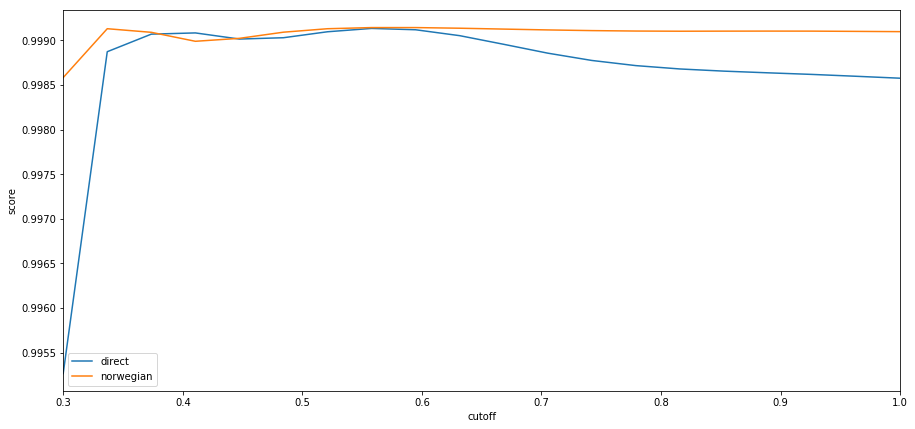

In [25]:
fig,ax = plt.subplots()
df_cuttoffs.plot(x='cutoff', y='score', ax=ax, label='direct')
df_cuttoffs_norwegian.plot(x='cutoff', y='score', ax=ax, label='norwegian')
ax.set_ylabel('score')

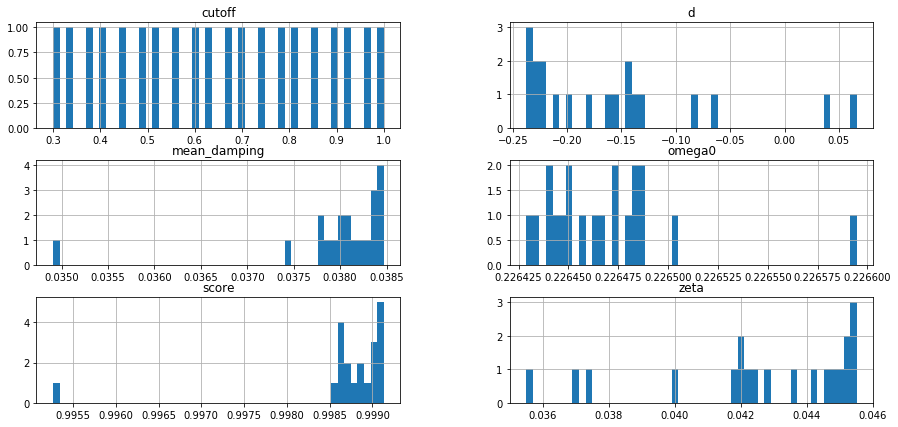

In [26]:
df_cuttoffs.hist(bins=50);

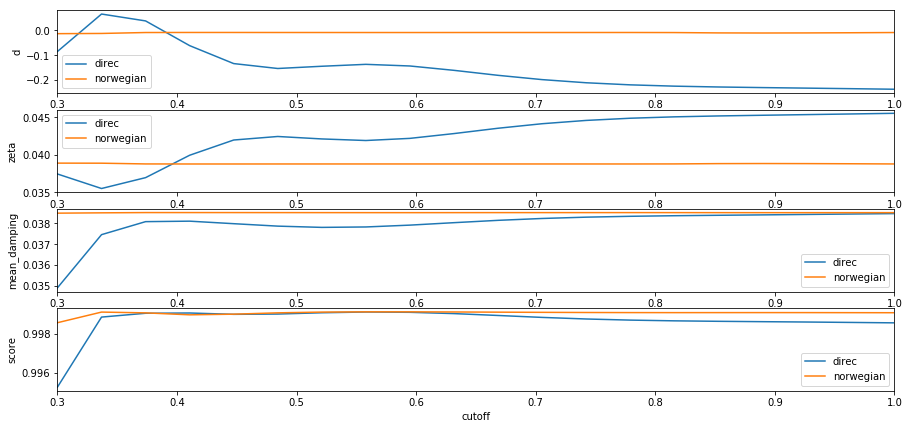

In [27]:
fig,axes = plt.subplots(nrows=4)

ys = ['d','zeta','mean_damping','score']

for ax,y in zip(axes,ys):
    df_cuttoffs.plot(x='cutoff', y=y, ax=ax, label='direc')
    df_cuttoffs_norwegian.plot(x='cutoff', y=y, ax=ax, label='norwegian')
    ax.legend()
    ax.set_ylabel(y)




### Optimize cutting

In [28]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=0.4)
lowpass_filter.fit(X=df_raw) 
scaler = ScaleFactorTransformer(scale_factor=29.565).fit(X=df_raw)

direct_estimator = DirectEstimator(ftol=10**-12)

def vary_start(phi_starts, phi_stops, estimator):
    df_starts = pd.DataFrame()
    
    for phi_start,phi_stop in zip(phi_starts,phi_stops):
        
        cutter = CutTransformer(phi_max=np.deg2rad(phi_start), phi_min=np.deg2rad(phi_stop)).fit(X=df_raw)
            
        steps = [
            ('filter',lowpass_filter),
            ('scaler',scaler),
            ('cutter', cutter), 
            ('estimator', estimator)]
        pipeline = Pipeline(steps) # define the pipeline object.
        
        pipeline.fit(X=df_raw)
        s = pd.Series(pipeline['estimator'].parameters)
        s['mean_damping'] = pipeline['estimator'].calculate_average_linear_damping()
        s['score'] = pipeline.score(X=df_raw)
        s['phi_start'] = phi_start
        s['phi_stop'] = phi_stop
        df_starts = df_starts.append(s, ignore_index=True)
        
    return df_starts

In [29]:
N=30
direct_linear_estimator = DirectLinearEstimator(ftol=10**-12)

phi_starts = np.linspace(2,5,N)
phi_stops = np.linspace(0.5,0.5,N)
df_direct = vary_start(phi_starts=phi_starts, phi_stops=phi_stops, estimator=direct_estimator);
df_direct_linear = vary_start(phi_starts=phi_starts, phi_stops=phi_stops, estimator=direct_linear_estimator);
df_direct_linear['d'] = 0
df_norwegian = vary_start(phi_starts=phi_starts, phi_stops=phi_stops, estimator=norwegian_estimator);



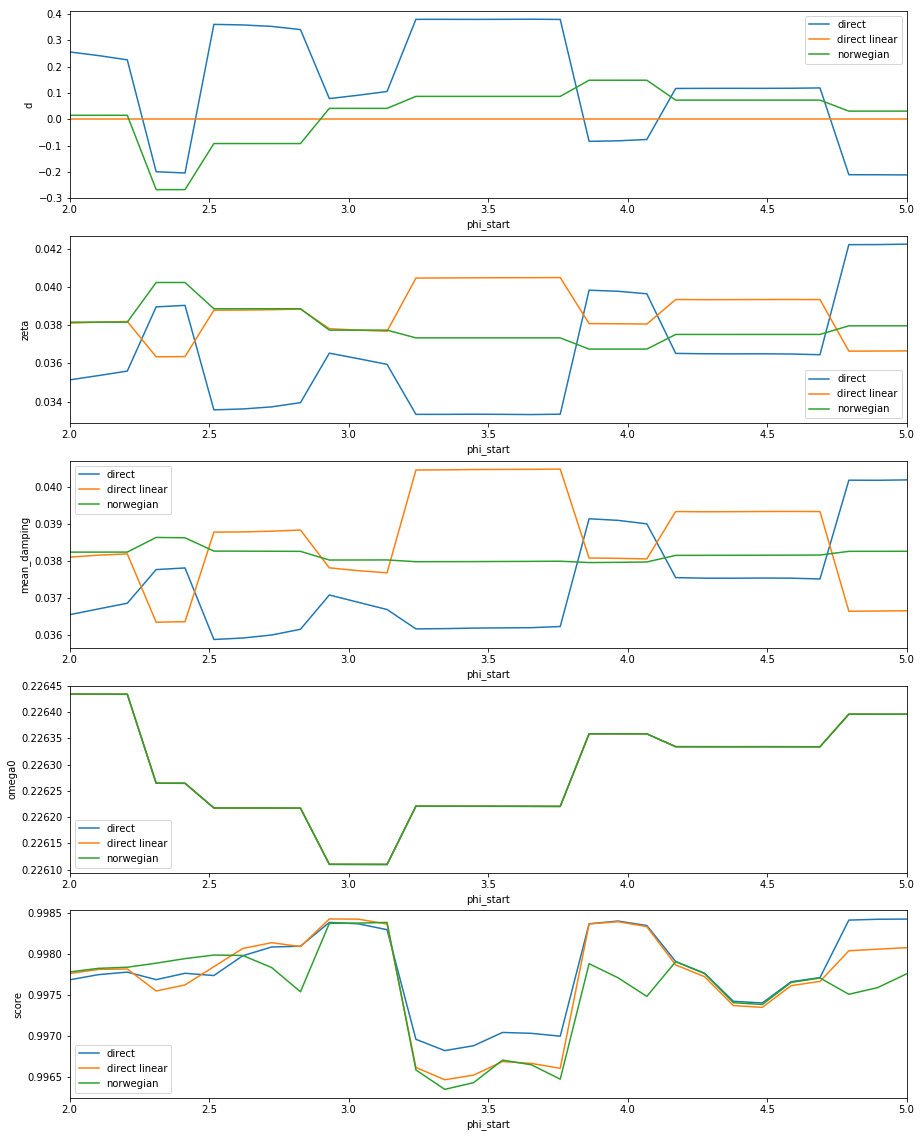

In [30]:
fig,axes = plt.subplots(nrows=5)
fig.set_size_inches(15,20)

ys = ['d','zeta','mean_damping','omega0','score']

for ax,y in zip(axes,ys):
    df_direct.plot(x='phi_start', y=y, ax=ax, label='direct')
    df_direct_linear.plot(x='phi_start', y=y, ax=ax, label='direct linear')
    df_norwegian.plot(x='phi_start', y=y, ax=ax, label='norwegian')
    ax.legend()
    ax.set_ylabel(y)

In [31]:
N=30
direct_linear_estimator = DirectLinearEstimator(ftol=10**-12)

phi_starts = np.linspace(7,7,N)
phi_stops = np.linspace(0,5,N)
df_direct = vary_start(phi_starts=phi_starts, phi_stops=phi_stops, estimator=direct_estimator);
df_direct_linear = vary_start(phi_starts=phi_starts, phi_stops=phi_stops, estimator=direct_linear_estimator);
df_direct_linear['d'] = 0
df_norwegian = vary_start(phi_starts=phi_starts, phi_stops=phi_stops, estimator=norwegian_estimator);

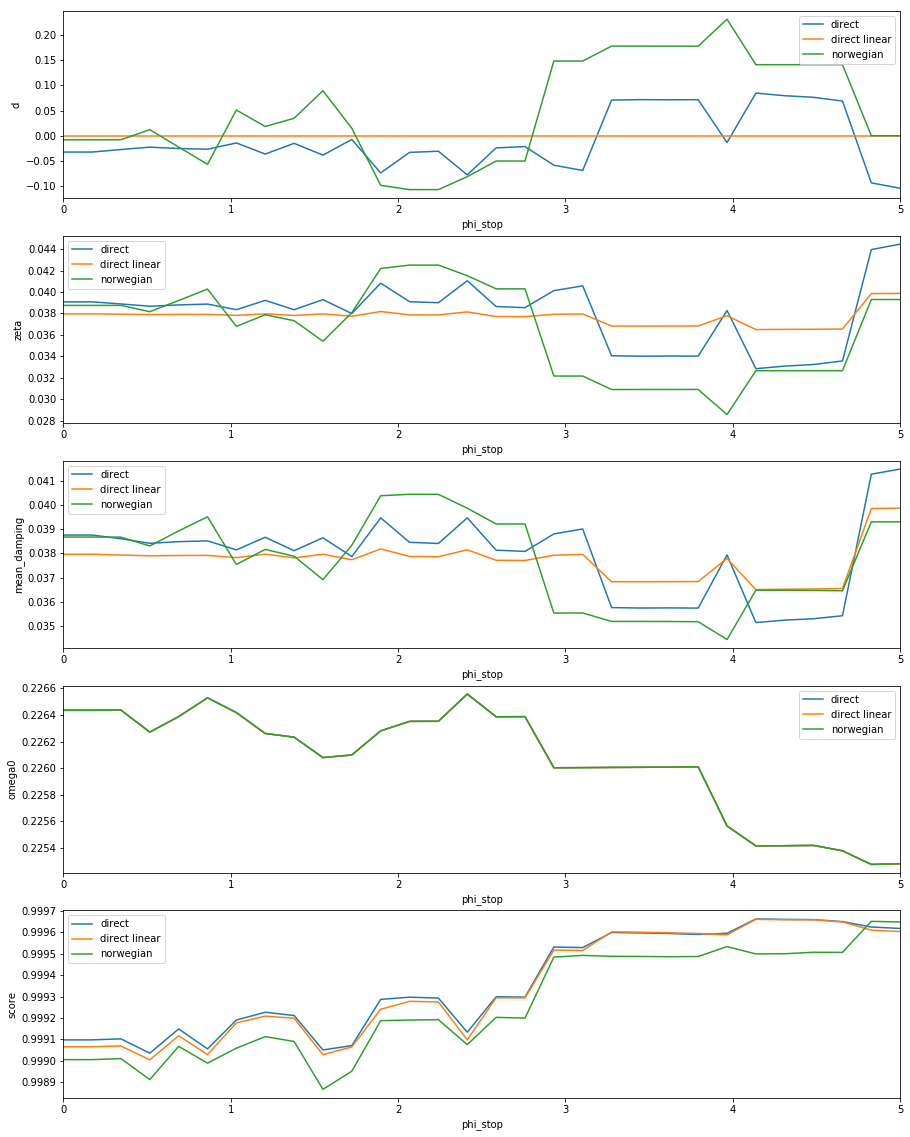

In [32]:
fig,axes = plt.subplots(nrows=5)
fig.set_size_inches(15,20)

ys = ['d','zeta','mean_damping','omega0','score']

for ax,y in zip(axes,ys):
    df_direct.plot(x='phi_stop', y=y, ax=ax, label='direct')
    df_direct_linear.plot(x='phi_stop', y=y, ax=ax, label='direct linear')
    df_norwegian.plot(x='phi_stop', y=y, ax=ax, label='norwegian')
    ax.legend()
    ax.set_ylabel(y)